# Quantum Espresso Energy Volume Curve Workflow with aiida

## Define workflow with jobflow

In [1]:
from python_workflow_definition.aiida import write_workflow_json

from aiida import load_profile
load_profile()

workflow_json_filename =  "aiida_to_pyiron_base_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph
from typing import Any

In [3]:
# NOTE: `get_dict` is `get_input_dict`, to compile the input values for the calc tasks
# NOTE: `add_link` must be from outputs to inputs
from python_workflow_definition.shared import get_dict, get_list

In [4]:
@task.pythonjob()
def pickle_node(value):
    """Handle data nodes"""
    return value

In [5]:
from quantum_espresso_workflow import generate_structures as _generate_structures
from quantum_espresso_workflow import get_bulk_structure as _get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve as _plot_energy_volume_curve

In [6]:
strain_lst = [0.9, 0.95, 1.0, 1.05, 1.1]

In [7]:
get_bulk_structure = task.pythonjob()(_get_bulk_structure)
generate_structures = task.pythonjob()(_generate_structures)
calculate_qe = task.pythonjob(outputs=["energy", "volume", "structure"])(
    _calculate_qe
)
plot_energy_volume_curve = task.pythonjob()(_plot_energy_volume_curve)

In [8]:
wg = WorkGraph("wg-qe")

In [9]:
pickle_element_task = wg.add_task(
    pickle_node,
    name="pickle_element",
    value="Al",
)

In [10]:
pickle_a_task = wg.add_task(
    pickle_node, name="pickle_a", value=4.05
)

In [11]:
pickle_cubic_task = wg.add_task(
    pickle_node, name="pickle_cubic", value=True
)

In [12]:
pickle_relax_workdir_task = wg.add_task(
    pickle_node,
    name="pickle_relax_workdir",
    value="mini",
)

In [13]:
# ? relax or SCF, or general? -> Should be relax
relax_get_dict_task = wg.add_task(
    task.pythonjob(
        # outputs=["structure", "calculation", "kpts", "pseudopotentials", "smearing"]
        # outputs=["dict"]
    )(get_dict),
    name="relax_get_dict",
    register_pickle_by_value=True,
)

In [14]:
pickle_pp_task = wg.add_task(
    pickle_node,
    name="pseudopotentials",
    value={"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"},
)

In [15]:
pickle_kpts_task = wg.add_task(
    pickle_node, name="kpts_task", value=[3, 3, 3]  # FIXME: Back to [3, 3, 3]
)

In [16]:
pickle_calc_type_relax_task = wg.add_task(
    pickle_node,
    name="calc_type_relax",
    value="vc-relax",
)

In [17]:
pickle_smearing_task = wg.add_task(
    pickle_node, name="smearing", value=0.02
)

In [18]:
strain_lst_task = wg.add_task(
    pickle_node,
    name="pickle_strain_lst",
    value=strain_lst,
)

In [19]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    register_pickle_by_value=True,
)

In [20]:
relax_task = wg.add_task(
    calculate_qe,
    # ! I don't like the `mini` name...
    name="mini",
    register_pickle_by_value=True,
)

In [21]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    register_pickle_by_value=True,
)

In [22]:
# here we add the structure outputs based on the number of strains
del wg.tasks.generate_structures.outputs["result"]

In [23]:
scf_qe_tasks = []
for i, strain in enumerate(strain_lst):
    generate_structures_task.add_output("workgraph.any", f"s_{i}")

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        register_pickle_by_value=True,
    )
    scf_qe_tasks.append(scf_qe_task)

In [24]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    register_pickle_by_value=True,
)

In [25]:
strain_dir_tasks, scf_get_dict_tasks = [], []
for i, strain in enumerate(strain_lst):
    strain_dir = f"strain_{i}"

    strain_dir_task = wg.add_task(
        pickle_node,
        name=f"pickle_{strain_dir}_dir",
        value=strain_dir,
        register_pickle_by_value=True,
    )
    strain_dir_tasks.append(strain_dir_task)

    scf_get_dict_task = wg.add_task(
        task.pythonjob()(get_dict),
        name=f"get_dict_{i}",
        register_pickle_by_value=True,
    )
    scf_get_dict_tasks.append(scf_get_dict_task)

    if i == 0:
        pickle_calc_type_scf_task = wg.add_task(
            pickle_node,
            name="calc_type_scf",
            value="scf",
        )

In [26]:
get_volumes_task = wg.add_task(
    task.pythonjob()(get_list),
    name="get_volumes",
    register_pickle_by_value=True,
)

In [27]:
get_energies_task = wg.add_task(
    task.pythonjob()(get_list),
    name="get_energies",
    register_pickle_by_value=True,
)

In [28]:
# Add remaining links
wg.add_link(
    pickle_element_task.outputs.result, get_bulk_structure_task.inputs.element
)
wg.add_link(pickle_a_task.outputs.result, get_bulk_structure_task.inputs.a)
wg.add_link(pickle_cubic_task.outputs.result, get_bulk_structure_task.inputs.cubic)

NodeLink(from="pickle_cubic.result", to="get_bulk_structure.cubic")

In [29]:
# `.set` rather than `.add_link`, as get_dict takes `**kwargs` as input
relax_get_dict_task.set(
    {
        "structure": get_bulk_structure_task.outputs.result,
        "calculation": pickle_calc_type_relax_task.outputs.result,
        "kpts": pickle_kpts_task.outputs.result,
        "pseudopotentials": pickle_pp_task.outputs.result,
        "smearing": pickle_smearing_task.outputs.result,
    }
)

In [30]:
wg.add_link(relax_get_dict_task.outputs.result, relax_task.inputs.input_dict)
wg.add_link(
    pickle_relax_workdir_task.outputs.result,
    relax_task.inputs.working_directory,
)

NodeLink(from="pickle_relax_workdir.result", to="mini.working_directory")

In [31]:
wg.add_link(relax_task.outputs.structure, generate_structures_task.inputs.structure)
wg.add_link(
    strain_lst_task.outputs.result, generate_structures_task.inputs.strain_lst
)

NodeLink(from="pickle_strain_lst.result", to="generate_structures.strain_lst")

In [32]:
for i, (scf_get_dict_task, scf_qe_task, strain_dir_task) in enumerate(
    list(zip(scf_get_dict_tasks, scf_qe_tasks, strain_dir_tasks))
):
    scf_get_dict_task.set(
        {
            "structure": generate_structures_task.outputs[f"s_{i}"],
            "calculation": pickle_calc_type_scf_task.outputs.result,
            "kpts": pickle_kpts_task.outputs.result,
            "pseudopotentials": pickle_pp_task.outputs.result,
            "smearing": pickle_smearing_task.outputs.result,
        }
    )
    wg.add_link(scf_get_dict_task.outputs.result, scf_qe_task.inputs.input_dict)
    wg.add_link(
        strain_dir_task.outputs.result, scf_qe_task.inputs.working_directory
    )

    # collect energy and volume
    # wg.add_link(scf_qe_task.outputs.energy, get_energies_task.inputs.kwargs)
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    # wg.add_link(scf_qe_task.outputs.volume, get_volumes_task.inputs.kwargs)
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [33]:
wg.add_link(
    get_volumes_task.outputs.result,
    plot_energy_volume_curve_task.inputs.volume_lst,
)

NodeLink(from="get_volumes.result", to="plot_energy_volume_curve.volume_lst")

In [34]:
wg.add_link(
    get_energies_task.outputs.result,
    plot_energy_volume_curve_task.inputs.energy_lst,
)

NodeLink(from="get_energies.result", to="plot_energy_volume_curve.energy_lst")

In [35]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [36]:
!cat {workflow_json_filename}

{
  "nodes": {
    "0": "Al",
    "1": 4.05,
    "2": true,
    "3": "mini",
    "4": "python_workflow_definition.shared.get_dict",
    "5": {
      "Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"
    },
    "6": [
      3,
      3,
      3
    ],
    "7": "vc-relax",
    "8": 0.02,
    "9": [
      0.9,
      0.95,
      1.0,
      1.05,
      1.1
    ],
    "10": "quantum_espresso_workflow.get_bulk_structure",
    "11": "quantum_espresso_workflow.calculate_qe",
    "12": "quantum_espresso_workflow.generate_structures",
    "13": "quantum_espresso_workflow.calculate_qe",
    "14": "quantum_espresso_workflow.calculate_qe",
    "15": "quantum_espresso_workflow.calculate_qe",
    "16": "quantum_espresso_workflow.calculate_qe",
    "17": "quantum_espresso_workflow.calculate_qe",
    "18": "quantum_espresso_workflow.plot_energy_volume_curve",
    "19": "strain_0",
    "20": "python_workflow_definition.shared.get_dict",
    "21": "scf",
    "22": "strain_1",
    "23": "python_workflow_definition.share

## Load Workflow with aiida

In [37]:
from python_workflow_definition.jobflow import load_workflow_json

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [38]:
from jobflow.managers.local import run_locally

In [39]:
flow = load_workflow_json(file_name=workflow_json_filename)

2025-03-22 09:38:57,271 INFO Started executing jobs locally
2025-03-22 09:38:57,360 INFO Starting job - get_bulk_structure (bc36be74-8c46-4923-be97-16ab7a7e1693)
2025-03-22 09:38:57,364 INFO Finished job - get_bulk_structure (bc36be74-8c46-4923-be97-16ab7a7e1693)
2025-03-22 09:38:57,365 INFO Starting job - get_dict (10dae56f-89a4-42d2-9554-bd29adb7b3f0)
2025-03-22 09:38:57,366 INFO Finished job - get_dict (10dae56f-89a4-42d2-9554-bd29adb7b3f0)
2025-03-22 09:38:57,367 INFO Starting job - calculate_qe (b93711f3-3365-492b-a2ca-4cb8d3762b7c)


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01801] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-22 09:39:50,621 INFO Finished job - calculate_qe (b93711f3-3365-492b-a2ca-4cb8d3762b7c)
2025-03-22 09:39:50,622 INFO Starting job - generate_structures (5123e54e-b9ef-4caf-9281-5a00cf4a4ebf)
2025-03-22 09:39:50,628 INFO Finished job - generate_structures (5123e54e-b9ef-4caf-9281-5a00cf4a4ebf)
2025-03-22 09:39:50,761 INFO Starting job - get_dict (76afdc8c-8656-4cfa-b900-0d130d9c844c)
2025-03-22 09:39:50,765 INFO Finished job - get_dict (76afdc8c-8656-4cfa-b900-0d130d9c844c)
2025-03-22 09:39:50,860 INFO Starting job - get_dict (486a6ea7-31ac-4c4a-a295-9df80f1bc6c7)
2025-03-22 09:39:50,863 INFO Finished job - get_dict (486a6ea7-31ac-4c4a-a295-9df80f1bc6c7)
2025-03-22 09:39:50,864 INFO Starting job - get_dict (e241fa28-81f9-468a-8ebb-156712cd117f)
2025-03-22 09:39:50,867 INFO Finished job - get_dict (e241fa28-81f9-468a-8ebb-156712cd117f)
2025-03-22 09:39:50,867 INFO Starting job - get_dict (70ec7201-be3a-4554-a458-c36b73434b32)
2025-03-22 09:39:50,870 INFO Finished job - get_dict (

[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01862] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-22 09:40:01,561 INFO Finished job - calculate_qe (a7c433bc-8a72-4809-a8c9-9ae9f3a60c9e)
2025-03-22 09:40:01,561 INFO Starting job - calculate_qe (f304e1a0-78c2-48e3-8c85-7655edab7f98)


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01872] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-03-22 09:40:14,760 INFO Finished job - calculate_qe (f304e1a0-78c2-48e3-8c85-7655edab7f98)
2025-03-22 09:40:14,761 INFO Starting job - calculate_qe (381133b7-b165-4d9a-8b57-cb865631f957)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01882] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-03-22 09:40:27,002 INFO Finished job - calculate_qe (381133b7-b165-4d9a-8b57-cb865631f957)
2025-03-22 09:40:27,003 INFO Starting job - calculate_qe (e3553123-a328-41f4-a75c-6ca2554e155b)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01892] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-22 09:40:40,483 INFO Finished job - calculate_qe (e3553123-a328-41f4-a75c-6ca2554e155b)
2025-03-22 09:40:40,484 INFO Starting job - calculate_qe (155ae32b-d7c9-4aa3-a5c6-4b98145f19e3)


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01902] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-03-22 09:40:54,282 INFO Finished job - calculate_qe (155ae32b-d7c9-4aa3-a5c6-4b98145f19e3)
2025-03-22 09:40:54,282 INFO Starting job - get_list (267bdfab-adae-4a90-be3f-2ad7b90f49d5)
2025-03-22 09:40:54,285 INFO Finished job - get_list (267bdfab-adae-4a90-be3f-2ad7b90f49d5)
2025-03-22 09:40:54,286 INFO Starting job - get_list (844cb3f8-f211-46f9-8f6e-a3353d9d8cc8)
2025-03-22 09:40:54,288 INFO Finished job - get_list (844cb3f8-f211-46f9-8f6e-a3353d9d8cc8)
2025-03-22 09:40:54,288 INFO Starting job - plot_energy_volume_curve (d8df5922-291f-4aa3-8094-011dd08da0d6)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-22 09:40:54,467 INFO Finished job - plot_energy_volume_curve (d8df5922-291f-4aa3-8094-011dd08da0d6)
2025-03-22 09:40:54,469 INFO Finished executing jobs locally


{'bc36be74-8c46-4923-be97-16ab7a7e1693': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

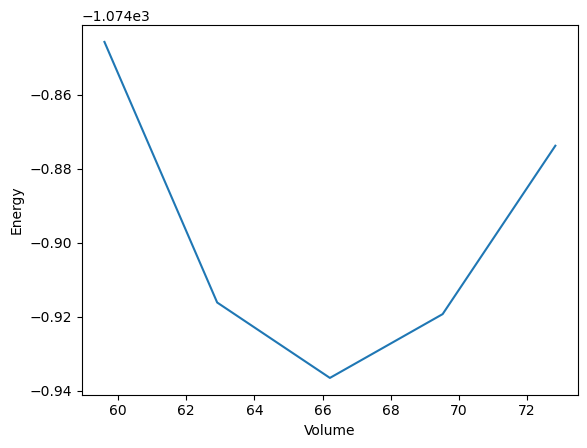

In [40]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [41]:
from pyiron_base import Project

In [42]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [43]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/2 [00:00<?, ?it/s]

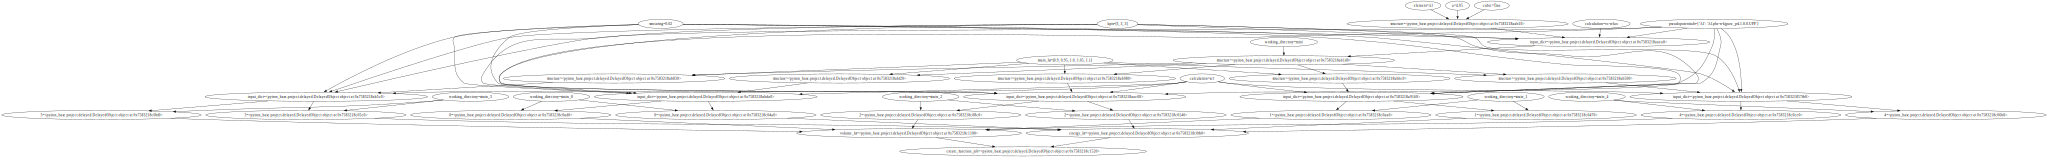

In [44]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 1
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 2
The job calculate_qe_22b5d0934d89d8f08761e744e4612c30 was saved and received the ID: 3


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01937] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_38d7db9bf0b2a6ead93f85c9894bec5c was saved and received the ID: 4
The job get_dict_81f98fa6da7d1297a8904234ed89403f was saved and received the ID: 5
The job calculate_qe_19ae744bdbea8a04ce337c048d65f4b9 was saved and received the ID: 6


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01948] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_3f5c7fd8f657f5929fadb4214b27d770 was saved and received the ID: 7
The job calculate_qe_4704b152a14764657ccea5ba307b6ff5 was saved and received the ID: 8


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01959] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_5728446bb43632d8cb992b26bf6c39e7 was saved and received the ID: 9
The job calculate_qe_1c8c2acc50e4848861ad84a6f2b53fcf was saved and received the ID: 10


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01971] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_72c035e1e890b1ffdf8e420b5148930e was saved and received the ID: 11
The job calculate_qe_bdd2f7518c2448e1f0d90abf1c355afc was saved and received the ID: 12


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01982] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_8a0ac6ff25761fb9c4ebd38c7959ef5d was saved and received the ID: 13
The job calculate_qe_fd2b692bafbc2399b47f95046f959c38 was saved and received the ID: 14


[jupyter-pyiron-dev-pyth-flow-definition-5o8yvjb0:01993] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_151b4c4bdbc4231d4edb7d4397a6437a was saved and received the ID: 15
The job get_list_b892c98b724d173a71d4c18f1cfd92e0 was saved and received the ID: 16
The job plot_energy_volume_curve_689f175fef4ef895ad6c00ed89ba306e was saved and received the ID: 17


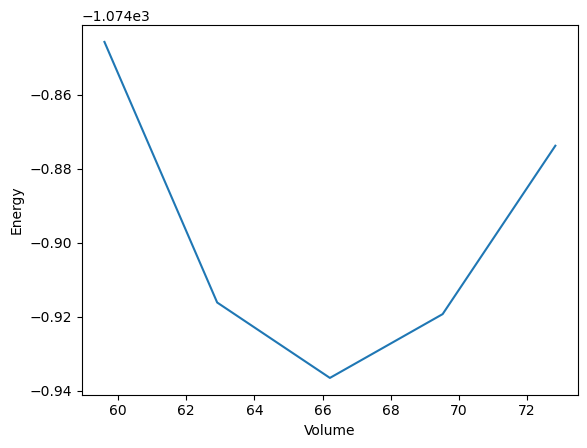

In [45]:
delayed_object.pull()